<a href="https://colab.research.google.com/github/jaeheonk817/KCHA_Project/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

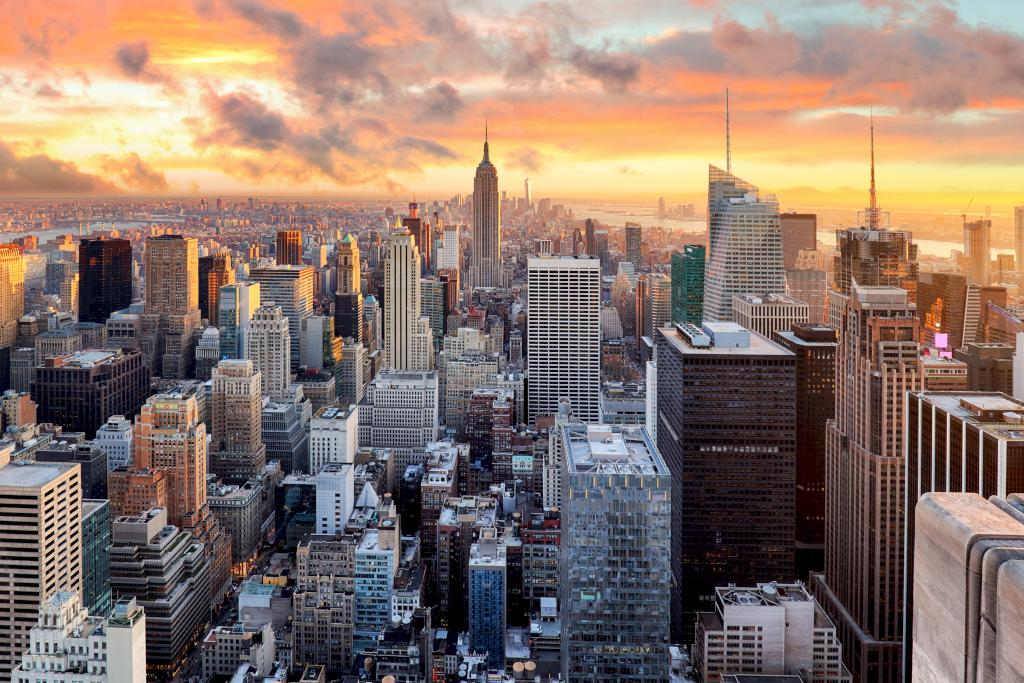

# Surface Crack Detection using CNN for NYC Department of Buildings
authored by Jae Heon Kim

## Overview

This data science project uses the CRISP-DM framework to develop a Convolutional Neural Network (CNN) model for classifying walls as either cracked or not-cracked based on image input. The project aims to provide an automated solution to identify areas for repair and maintenance in buildings. The steps involved include understanding the problem statement and defining the business goal, gathering and preparing the data, developing the model, evaluating its performance, and deploying it for use. The end result is a trained model that can accurately classify walls as cracked or not-cracked based on image input.

## Business Understanding
The stakeholder for this CRISP-DM data science project is the NYC Department of Buildings. The problem they face is that current inspection methods are outdated, costly, time-consuming, and less accurate due to human imperfections. This means that required inspections are not being completed on time, and there is a need for a more efficient and accurate solution. The stakeholder is interested in a model that can help digitize this inspection process, particularly with detecting building cracks. The goal of this project is to train a convolutional neural network (CNN) model that can accurately classify walls as cracked or not-cracked based on image input, thus providing a more automated and accurate solution for building inspections. By achieving this goal, the NYC Department of Buildings can improve the accuracy and efficiency of their inspection process, ultimately leading to cost savings and more timely inspections, which in turn can benefit and protect everyone living and working in New York City.

## Data Understanding

The dataset consists of 40,000 images of concrete surfaces with and without cracks, divided into two separate folders for negative (without crack) and positive (with crack) image classification. Each class has 20,000 images with a resolution of 227 x 227 pixels with RGB channels. The data is generated from 458 high-resolution images (4032x3024 pixel) using the method proposed by Zhang et al. (2016). No data augmentation in terms of random rotation or flipping or tilting is applied. The dataset is contributed by Çağlar Fırat Özgenel and was previously used in a study comparing the performance of pre-trained Convolutional Neural Networks (CNNs) on crack detection in buildings (Özgenel & Gönenç Sorguç, 2018). The dataset can be used for classifying crack and non-crack images and for creating a mask of the cracked portion in new images using image segmentation methods.

Source: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection

## Data Preparation

### Creating Data Access
Start by creating access to the data files in the github repository.

In [ ]:
# !git clone https://github.com/jaeheonk817/project_surface-crack-detection

### Imports

Import all necessary pacakges.

In [ ]:
# Import basic pacakges
import numpy as np
import pandas as np

# Import visualization pacakges
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import image processing packages
from PIL import Image, ImageOps

# Import sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

# Import tensorflow packages
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

# Import miscellaneous packesgs
import os
import random
import shutil
from google.colab import drive

### Observing Raw Data

Randomly pull 15 images from cracked wall images and normal wall images from the data. `Positive` directory contains cracked images while `Negative` driectory contains uncracked images.

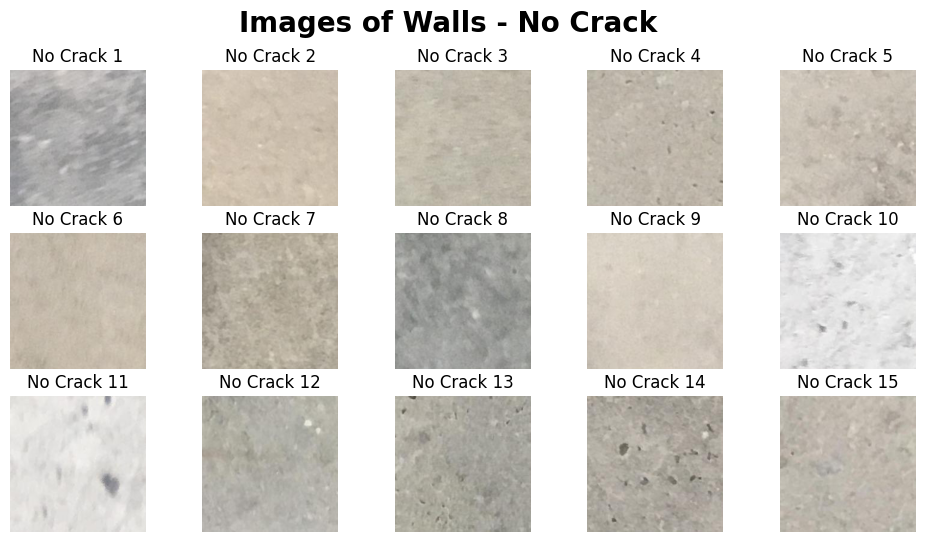

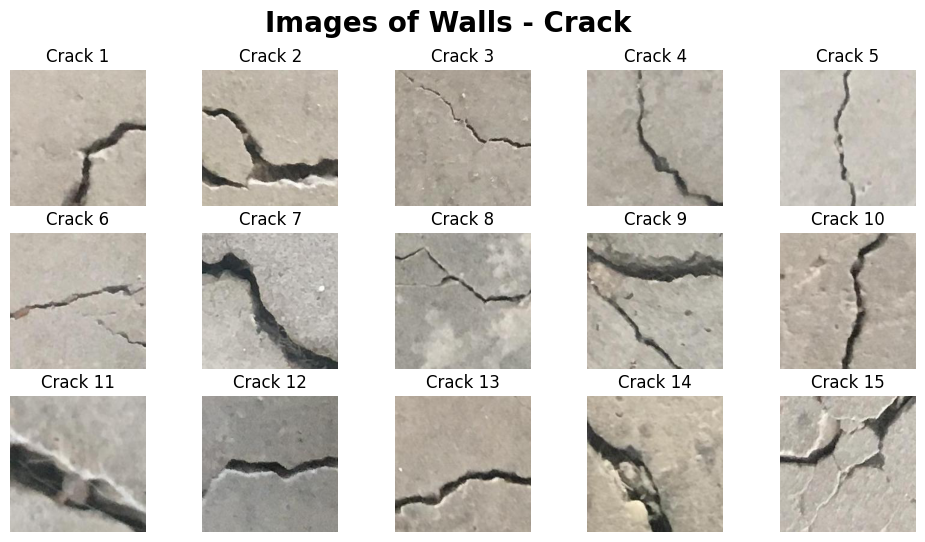

In [ ]:
# Assign directory paths to negative and positive data
negative_dir = '/content/project_surface-crack-detection/data/Negative'
positive_dir = '/content/project_surface-crack-detection/data/Positive'

# Randomly pull fifteen negative images
negative_files = os.listdir(negative_dir)
random.shuffle(negative_files)
negative_files_random = negative_files[:15]

# Randomly pull fifteen positive images
positive_files = os.listdir(positive_dir)
random.shuffle(positive_files)
positive_files_random = positive_files[:15]

# Plot random negative images
fig, ax = plt.subplots(3, 5, figsize=(12, 6))
for i in range(15):
    row = i // 5
    col = i % 5
    image_path = os.path.join(negative_dir, negative_files_random[i])
    image = plt.imread(image_path)
    ax[row, col].imshow(image)
    ax[row, col].axis('off')
    ax[row, col].set_title(f'No Crack {i+1}')
plt.suptitle("Images of Walls - No Crack", fontsize=20, fontweight='bold')
plt.show()
print("\n\n\n")

# Plot random positive images
fig, ax = plt.subplots(3, 5, figsize=(12, 6))
for i in range(15):
    row = i // 5
    col = i % 5
    image_path = os.path.join(positive_dir, positive_files_random[i])
    image = plt.imread(image_path)
    ax[row, col].imshow(image)
    ax[row, col].axis('off')
    ax[row, col].set_title(f'Crack {i+1}')
plt.suptitle("Images of Walls - Crack", fontsize=20, fontweight='bold')
plt.show()
print("\n\n\n")

- Some no-crack images have patterns that the model can mis interpret as cracks.
- Some crack images have very thin cracks that the model can mistake for a lined pattern.

While most images are easily distinguishable there are some images on the borderline that are difficult to calssify.

### Splitting Data into Train, Validation and Test Set

We will use train_test_split method from sklearn to make a split. We will first split data into `training set` (train set + validation set) and `test set`. Then, We will further split the `training set` into `train set` and `validation set`.

In [ ]:
# Assign directory paths
train_positive_dir = '/content/project_surface-crack-detection/data/train/positive'
train_negative_dir = '/content/project_surface-crack-detection/data/train/negative'
val_positive_dir = '/content/project_surface-crack-detection/data/val/positive'
val_negative_dir = '/content/project_surface-crack-detection/data/val/negative'
test_positive_dir = '/content/project_surface-crack-detection/data/test/positive'
test_negative_dir = '/content/project_surface-crack-detection/data/test/negative'

# Create directories
os.makedirs(train_positive_dir)
os.makedirs(train_negative_dir)
os.makedirs(val_positive_dir)
os.makedirs(val_negative_dir)
os.makedirs(test_positive_dir)
os.makedirs(test_negative_dir)

In [ ]:
# First split data into training set and test set
training_positive_files, test_positive_files = train_test_split(positive_files, test_size=0.1, random_state=817)
training_negative_files, test_negative_files = train_test_split(negative_files, test_size=0.1, random_state=817)

# Then split traning data into train set and validation set
train_positive_files, val_positive_files = train_test_split(training_positive_files, test_size=(1/9), random_state=817)
train_negative_files, val_negative_files = train_test_split(training_negative_files, test_size=(1/9), random_state=817)

In [ ]:
def copy_files(src_dir, src_list, dst_dir):
    """This function copies files in src_list from src_dir to dst_dir."""
    for filename in src_list:
        file_path = os.path.join(src_dir, filename)
        if os.path.isfile(file_path):
            shutil.copy(file_path, dst_dir)

In [ ]:
# Fill created positive directories with positive files
copy_files(positive_dir, train_positive_files, train_positive_dir)
copy_files(positive_dir, val_positive_files, val_positive_dir)
copy_files(positive_dir, test_positive_files, test_positive_dir)

# Fill created negative directories with negative files
copy_files(negative_dir, train_negative_files, train_negative_dir)
copy_files(negative_dir, val_negative_files, val_negative_dir)
copy_files(negative_dir, test_negative_files, test_negative_dir)

We will now check if splitting and assigning had been conducted successfully by checking number of files, visualizing random samples from each directory.

In [ ]:
def print_file_counts(file_directory):
    """This function prints the number of files in the given directory."""
    print(f"Number of files in {file_directory}: {len(os.listdir(file_directory))}")


In [ ]:
# Check how many files are in each directory
print_file_counts(train_positive_dir)
print_file_counts(train_negative_dir)
print_file_counts(val_positive_dir)
print_file_counts(val_negative_dir)
print_file_counts(test_positive_dir)
print_file_counts(test_negative_dir)

Number of files in /content/project_surface-crack-detection/data/train/positive: 16000
Number of files in /content/project_surface-crack-detection/data/train/negative: 16000
Number of files in /content/project_surface-crack-detection/data/val/positive: 2000
Number of files in /content/project_surface-crack-detection/data/val/negative: 2000
Number of files in /content/project_surface-crack-detection/data/test/positive: 2000
Number of files in /content/project_surface-crack-detection/data/test/negative: 2000


In [ ]:
# Create a function that will take random 10 sample images from each directory and plot them
def plot_sample_images(file_directory):
    """This function takes a file directory as input and plots random 10 images in that directory."""
    files = os.listdir(file_directory)
    random.shuffle(files)
    random_files = files[:10]
    fig, ax = plt.subplots(2, 5, figsize=(12, 6))
    for i in range(10):
        row = i // 5
        col = i % 5
        image_path = os.path.join(file_directory, random_files[i])
        image = plt.imread(image_path)
        ax[row, col].imshow(image)
        ax[row, col].axis('off')
        plt.suptitle(f"Sample Images from\n{file_directory}", fontsize=20, fontweight='bold')
    plt.show()

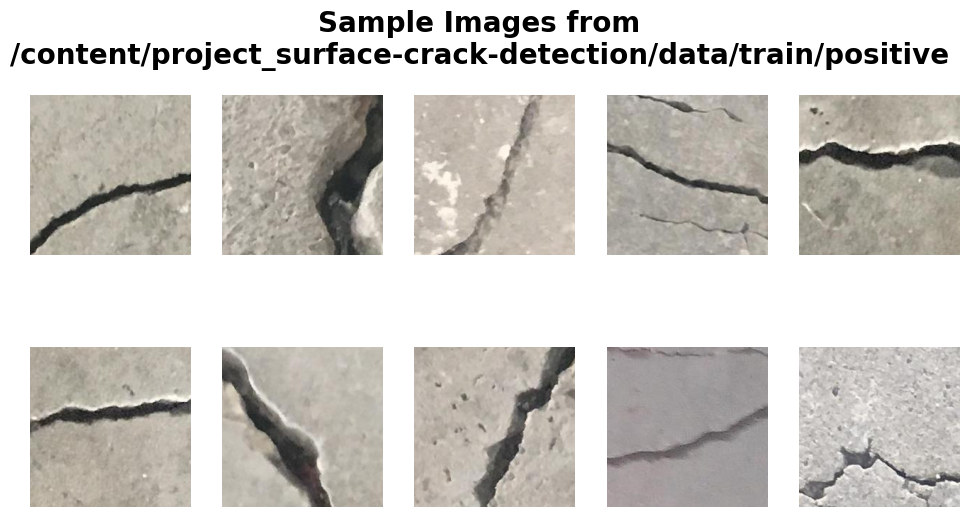

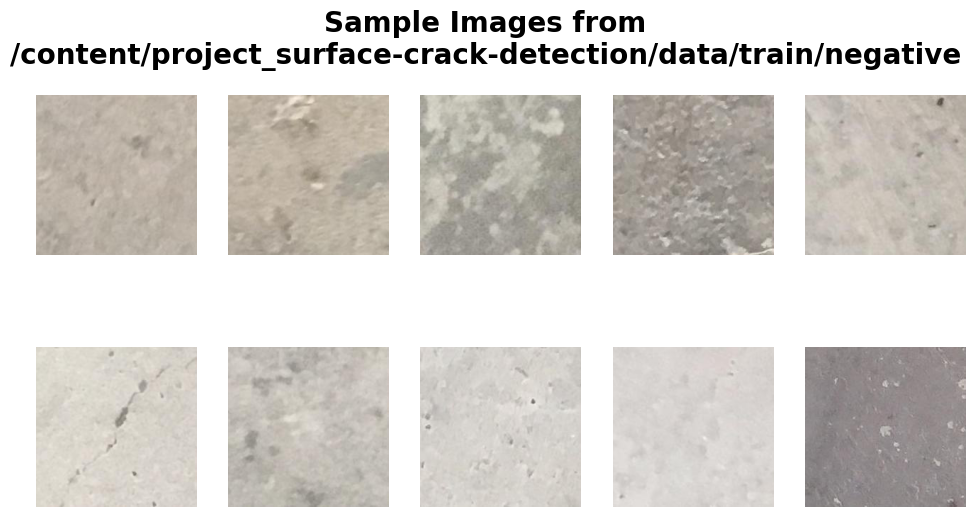

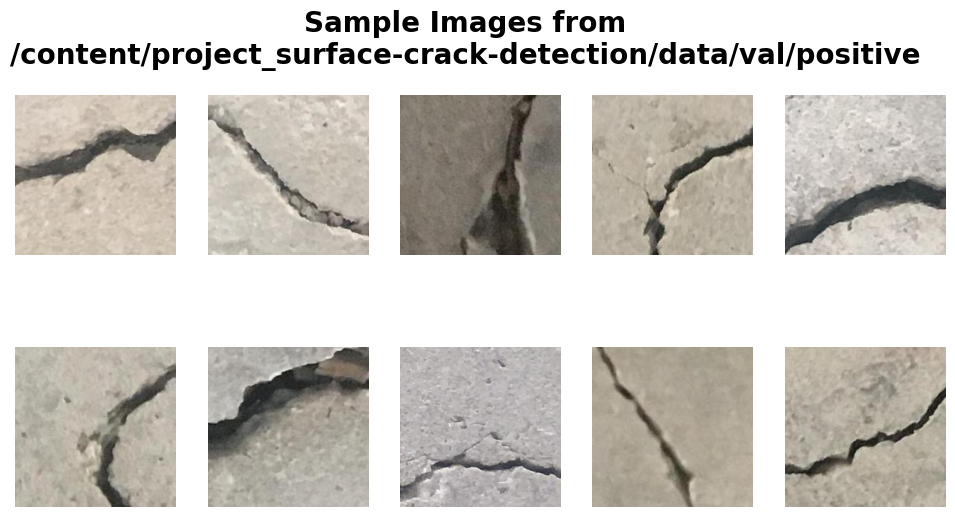

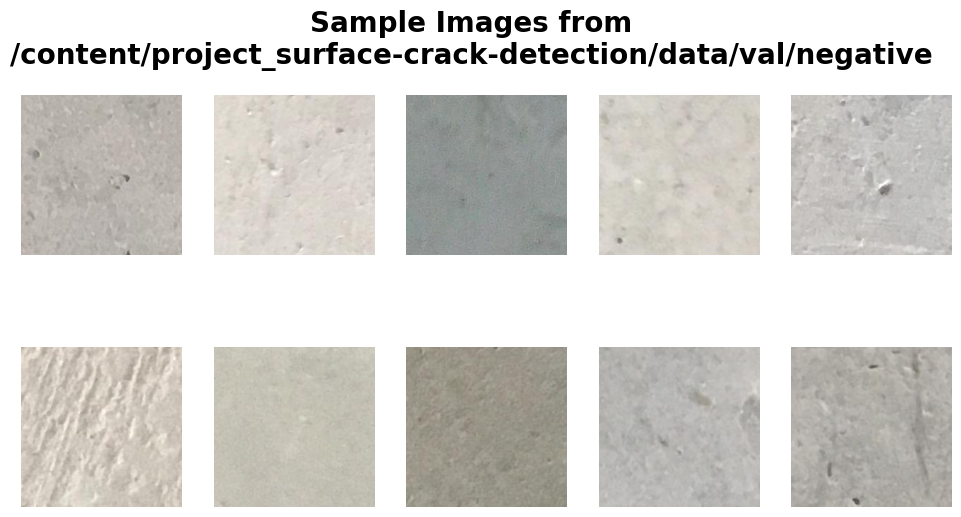

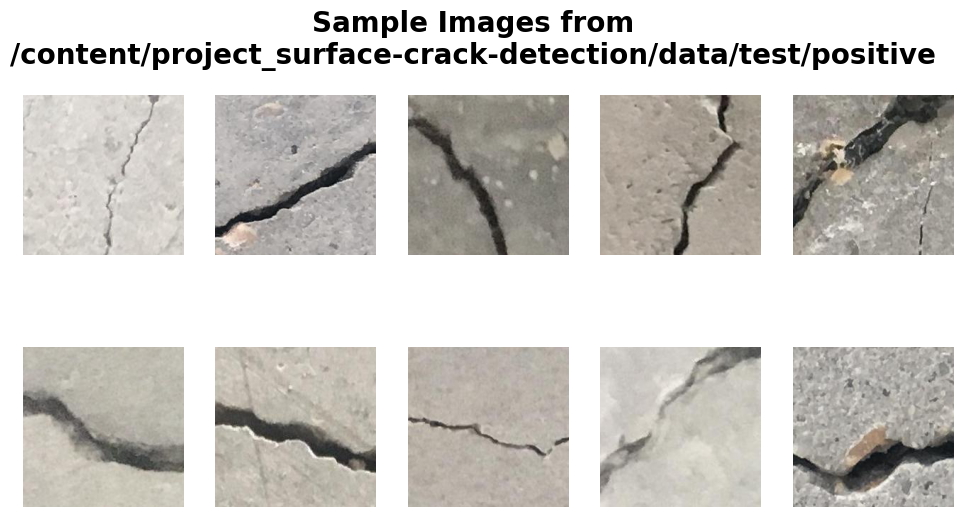

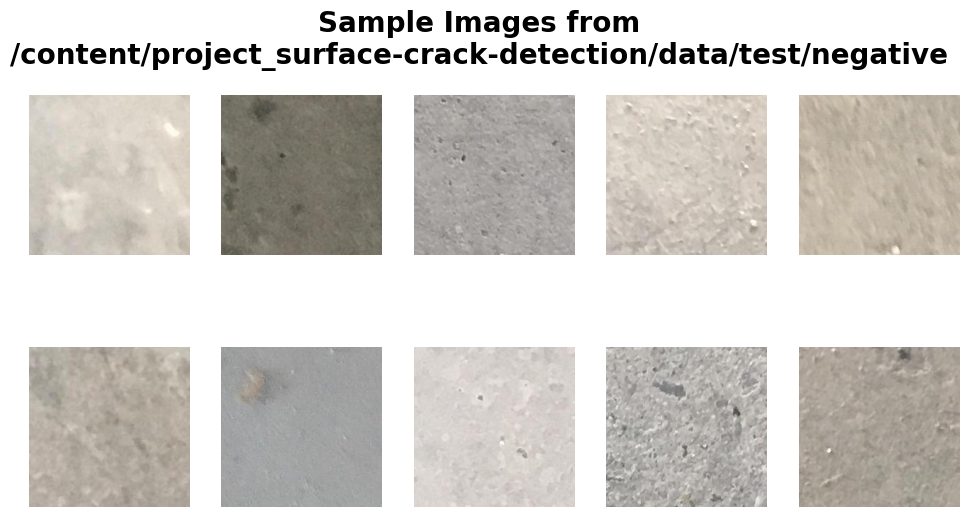

In [ ]:
# Print 10 random images from each directory
plot_sample_images(train_positive_dir)
print("\n\n")
plot_sample_images(train_negative_dir)
print("\n\n")
plot_sample_images(val_positive_dir)
print("\n\n")
plot_sample_images(val_negative_dir)
print("\n\n")
plot_sample_images(test_positive_dir)
print("\n\n")
plot_sample_images(test_negative_dir)

It seems certain now all the work related to splitting data is done correctly.

In [ ]:
!git clone <repository_url>


## Modeling
We will finally start building models. Our baseline model will be a cnn model with a single flatten hidden layer. Subsequent models will get more complicated with fine-tuning and other techniques associated with deep-learning image processing. We will save every model and and its metrics. The metrics will be used for comparison choose a final model and we will call back on the saved final model for deployment.

In [ ]:
# Create a directory to save models
os.makedirs('models')

# Create a dictionary to store each model's results
models_results_dict = {'model':[],
                       'accuracy':[],
                       'precision':[],
                       'recall':[]}

## Evaluation

## Conclusion

## Next Steps

# Code Notes - To be deleted after work is complete